## Sales Prediction for 1C Company


### BACKGROUND

This is a time-series dataset which contains daily sales data of the largest Russian software firms - 1C Company.

**Column list:**

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

### PROBLEM STATEMENT

Predict total sales for next 3-4 months

### DATA EXPLORATION and CLEANING

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from datetime import datetime, date
plt.rcParams.update({'font.size': 16})
from statsmodels.tsa.stattools import adfuller
import requests
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import display, Markdown, Latex
from sklearn.metrics import mean_absolute_error
import itertools

Let us read the data

In [2]:
mypath =  r'G:\My Drive\Dropbox\IIM-Aditya\Teaching\Executive courses\MSDSM -Business Analytics\codes\TSA&F\\'

df = pd.read_csv(mypath+ r'sales_train.csv',engine='python', skipfooter=3)

df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
data=df
data.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


Check if there are any NULL values and check the data types of the variables

In [4]:
data.count()

date              2935846
date_block_num    2935846
shop_id           2935846
item_id           2935846
item_price        2935846
item_cnt_day      2935846
dtype: int64

In [5]:
data.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

Let us see the unique values for shop ID and and item ID

In [6]:
data.groupby(data.shop_id).count().sort_values(['date'], ascending=False).head(2)

,date,date_block_num,item_id,item_price,item_cnt_day
shop_id,,,,,
31,235636,235636,235636,235636,235636
25,186101,186101,186101,186101,186101


In [7]:
data.groupby(data.item_id).count().sort_values(['date'], ascending=False).head(2)

,date,date_block_num,shop_id,item_price,item_cnt_day
item_id,,,,,
20949,31340,31340,31340,31340,31340
5822,9408,9408,9408,9408,9408


Since, *item_cnt_day* can only be an integer, let us change the values to integer type by ceiling it into next higher level.

In [8]:
# data['item_cnt_day']=np.ceil(data.item_cnt_day)
try:
    data.item_cnt_day=data.item_cnt_day.astype(int)
except:
    print("Already done")

In [9]:
data_31=data.copy()

Let us see the graph representing  number of products sold in 33 months.

C:\Users\adityam\AppData\Local\Temp\ipykernel_19544\780070184.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y=data_31.groupby(['date_block_num']).sum()['item_cnt_day']


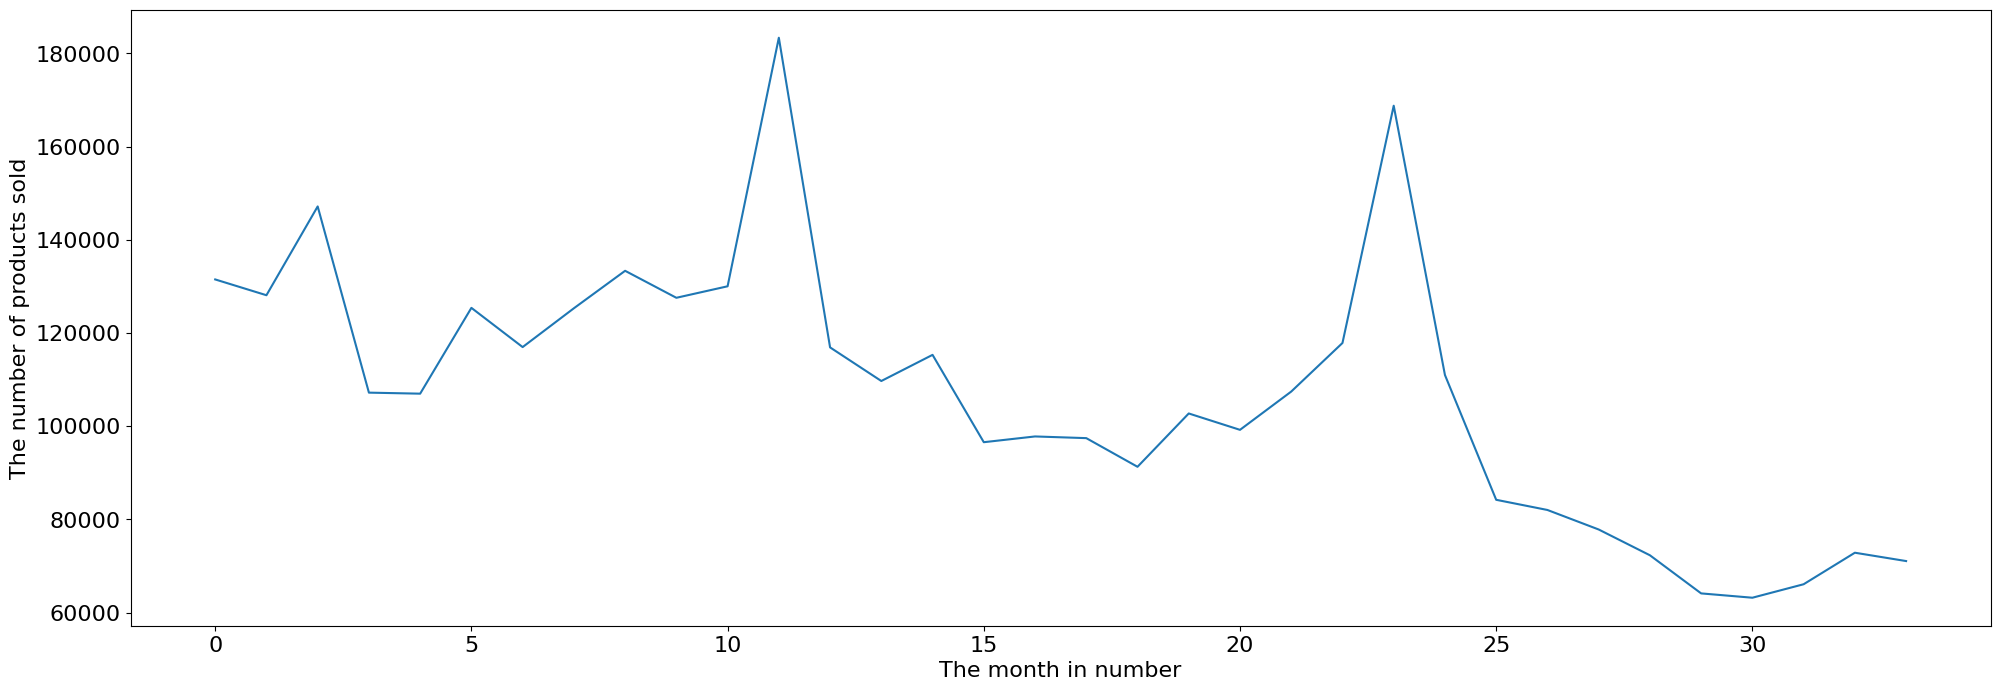

In [10]:
plt.rcParams.update({'font.size': 16})
y=data_31.groupby(['date_block_num']).sum()['item_cnt_day']
grouped_df=pd.DataFrame({"Total products": y})
grouped_df=grouped_df.reset_index(level=['date_block_num'])
plt.figure(figsize=(24,8))


sns.lineplot(x=grouped_df['date_block_num'],y=grouped_df['Total products'])
plt.ylabel("The number of products sold")
plt.xlabel("The month in number")
plt.show()

We can see that there is a decreasing trend. To comment on the seasonality, we need to check with respect to the time series. Let us change the Date column into TS object.

In [11]:
data_31['Month-Year'] = data_31.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y-%m'))

Let us change the column names for simplicity

In [12]:
data_31['Total_products_sold']=data_31['item_cnt_day']

In [13]:
data_31.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Month-Year,Total_products_sold
0,02.01.2013,0,59,22154,999.0,1,2013-01,1
1,03.01.2013,0,25,2552,899.0,1,2013-01,1


We will keep only the 'Month-Year' and 'Total products sold' columns for analysis

In [14]:
ts=data_31.groupby(['Month-Year']).sum()['Total_products_sold']
ts_df=pd.DataFrame(ts)

C:\Users\adityam\AppData\Local\Temp\ipykernel_19544\753042504.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ts=data_31.groupby(['Month-Year']).sum()['Total_products_sold']


pandas.core.series.Series

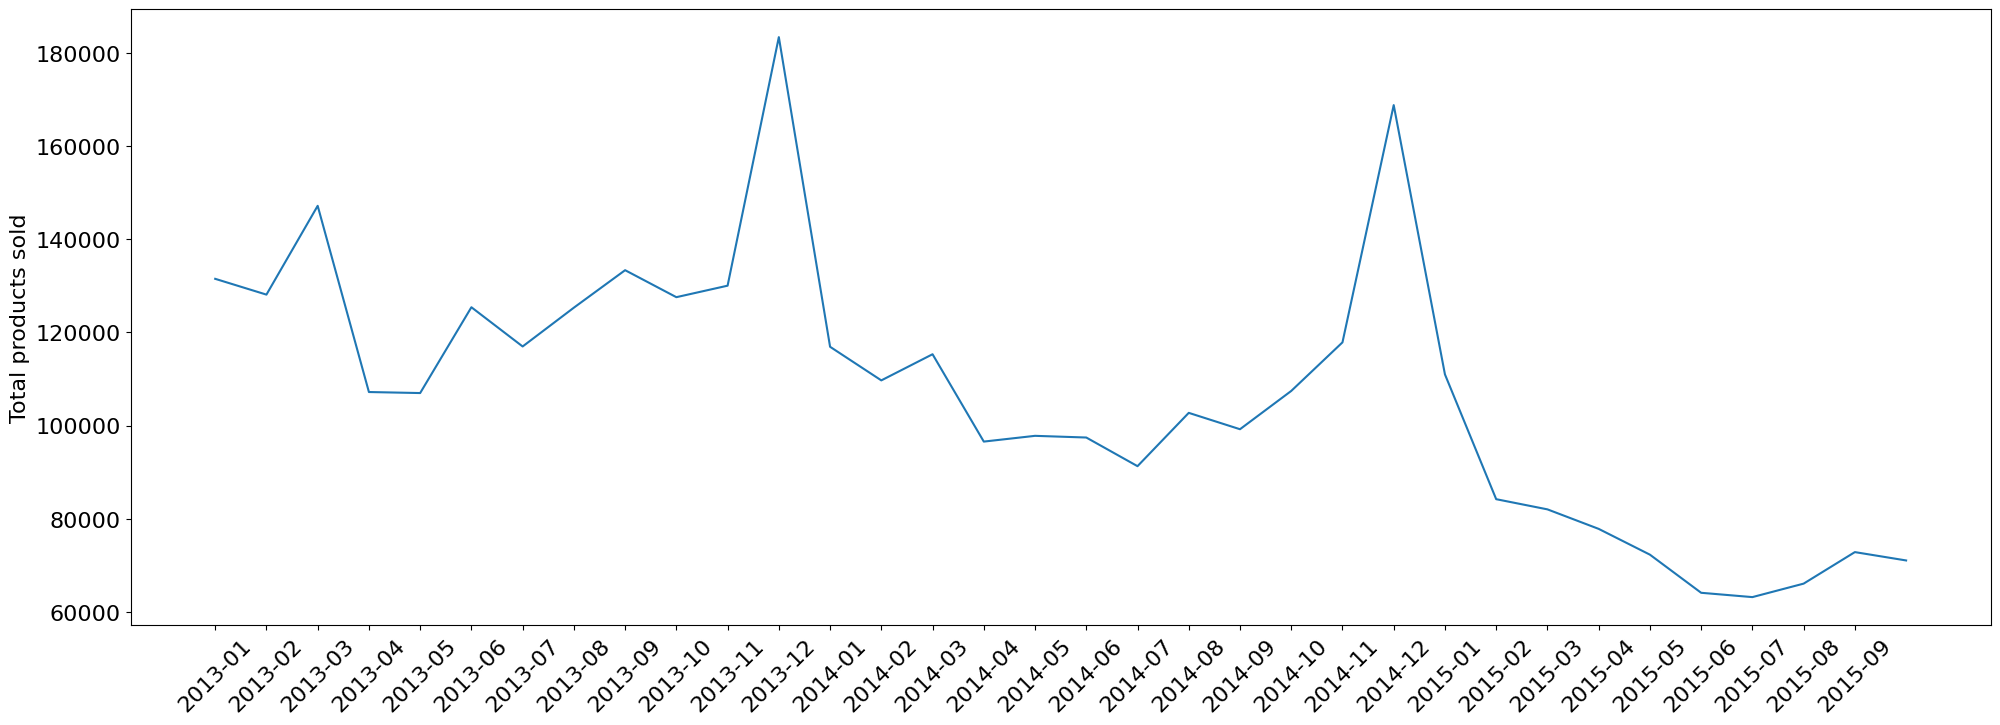

In [15]:
plt.figure(figsize=(24,8))
tick_locations=[value for value in np.arange(33)]
plt.xticks(tick_locations, rotation=45)
plt.ylabel("Total products sold")
plt.plot(ts)

### STATIONARIZE TIME SERIES

### Dicker Fuller Test
It is clearly evident that there is an overall decreasing trend in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences. So, more formally, we can check stationarity using the Dicker Fuller Test.

This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for different confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary

In [16]:

def test_stationarity(timeseries):
    
    #Determing rolling statistics
#     ts_log.rolling(12).mean()
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(24,8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    tick_locations=[value for value in np.arange(33)]
    plt.xticks(tick_locations, rotation=45)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

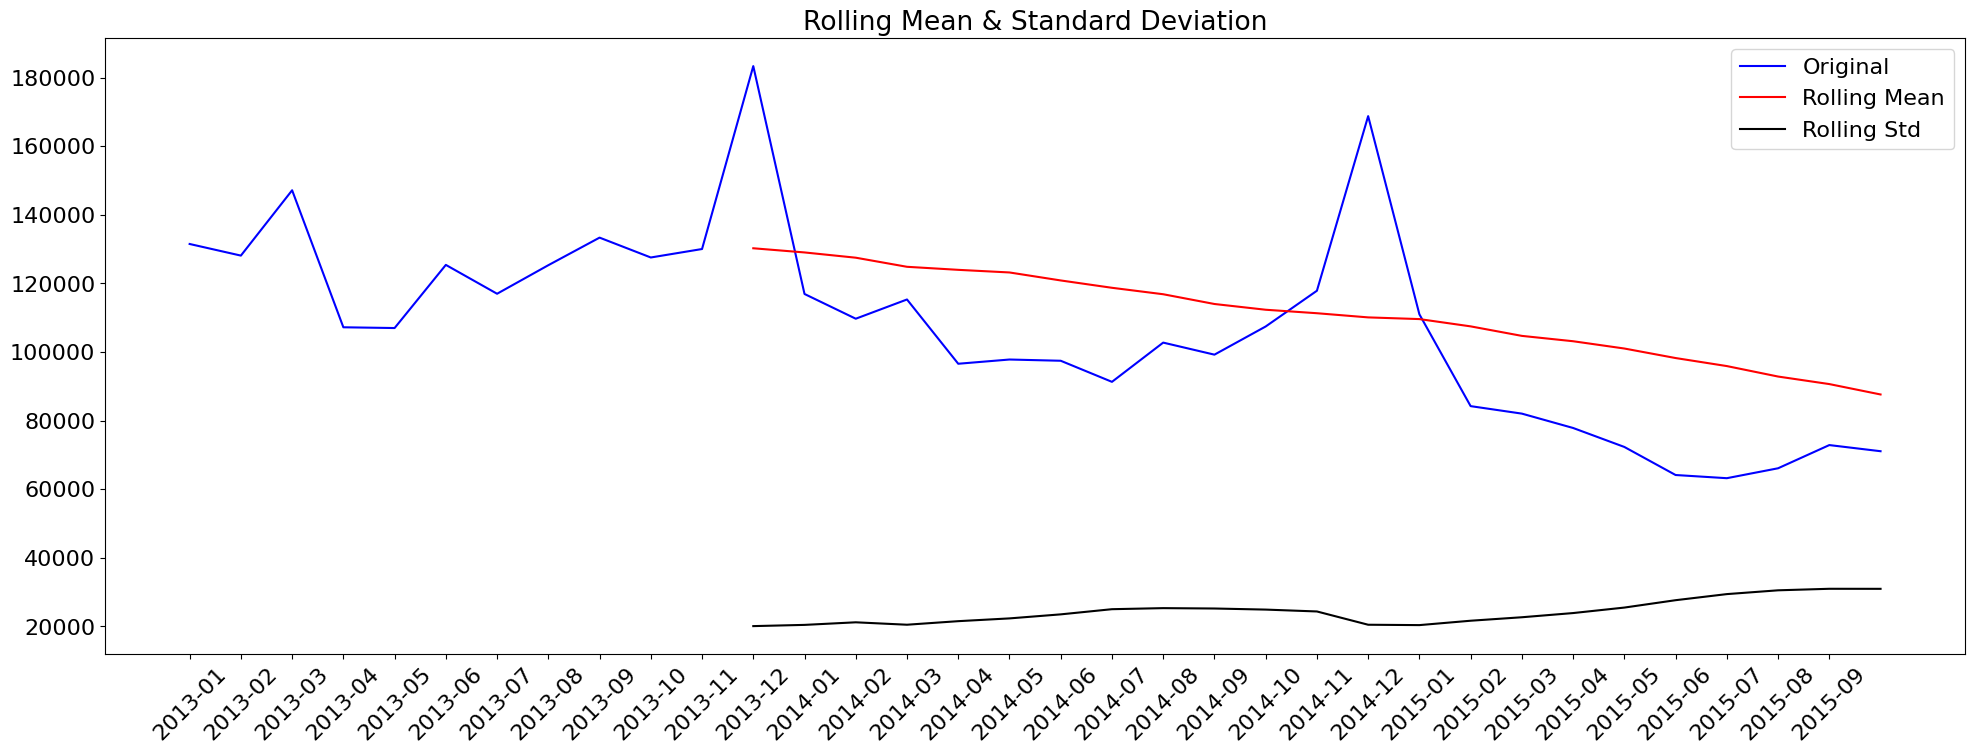

Results of Dickey-Fuller Test:
Test Statistic                 -2.395668
p-value                         0.142963
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [17]:
plt.rcParams.update({'font.size': 16})
test_stationarity(ts_df)


Since p >0.05 and test statistic > critical values, we accept Null hypothesis which states that it is non stationary. We need to change to stationary.

There are many techniques with which we can stationarize a model. Let us first proceed with moving average. Although moving average do not perform well when there is seasonality. Let see

**Moving average**

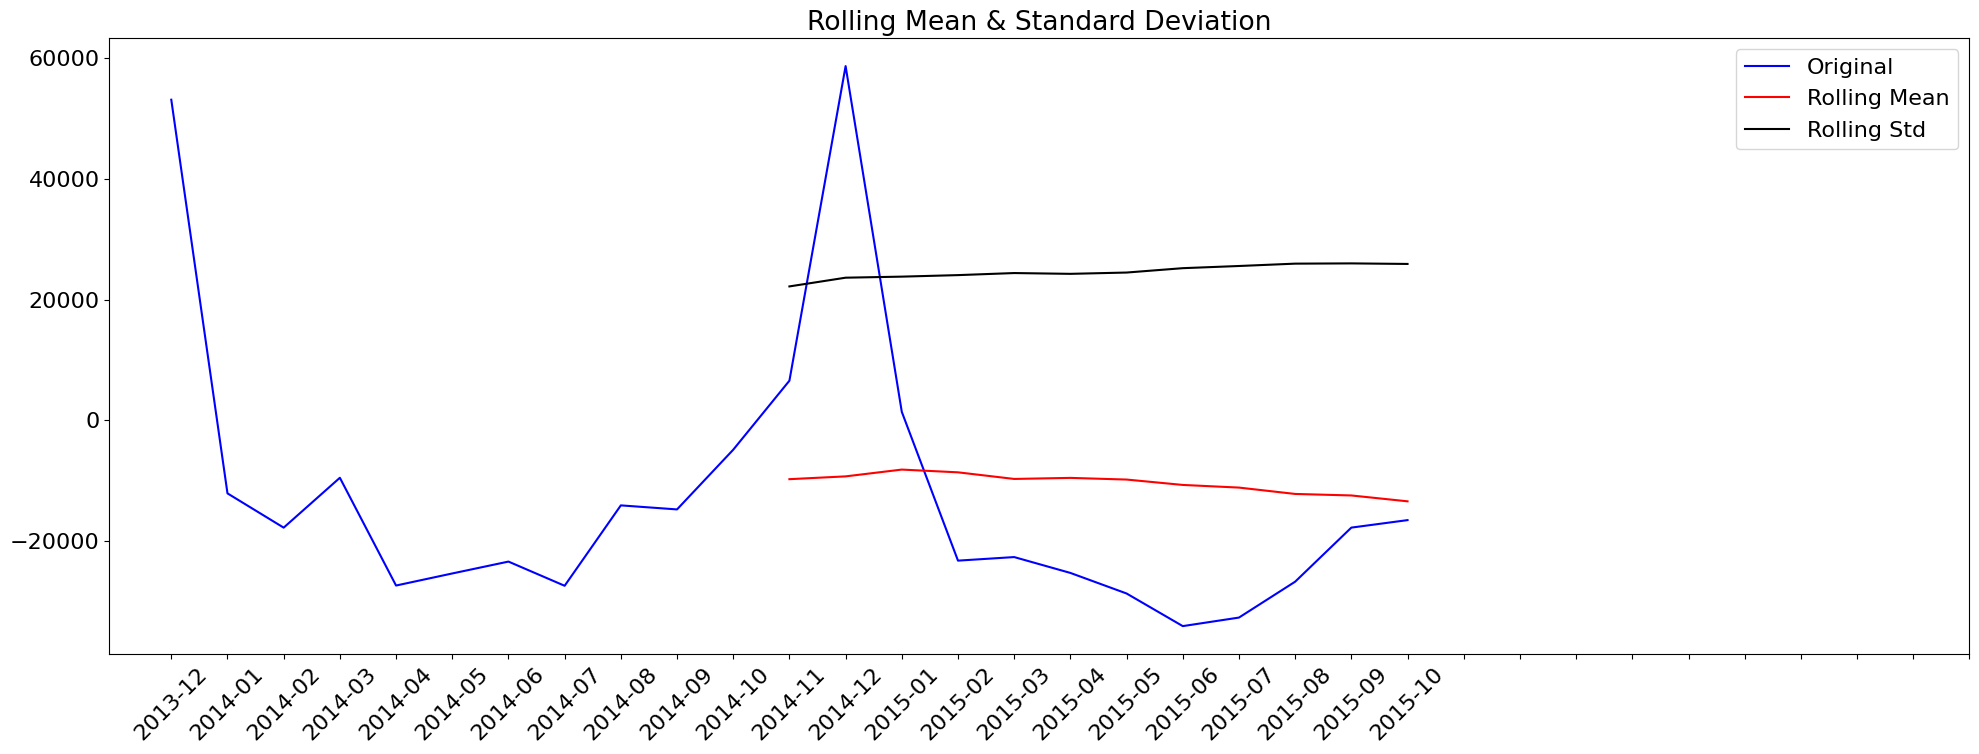

Results of Dickey-Fuller Test:
Test Statistic                 -4.010625
p-value                         0.001356
#Lags Used                      0.000000
Number of Observations Used    22.000000
Critical Value (1%)            -3.769733
Critical Value (5%)            -3.005426
Critical Value (10%)           -2.642501
dtype: float64


In [18]:
plt.rcParams.update({'font.size': 16})

moving_avg = ts.rolling(12).mean()
ts_movingavg_diff=ts-moving_avg
ts_movingavg_diff.dropna(inplace=True)
test_stationarity(ts_movingavg_diff)

From above test we can see that, the ts is stationary now. Let us also check for some other methods for better results.

**De trend by differencing**

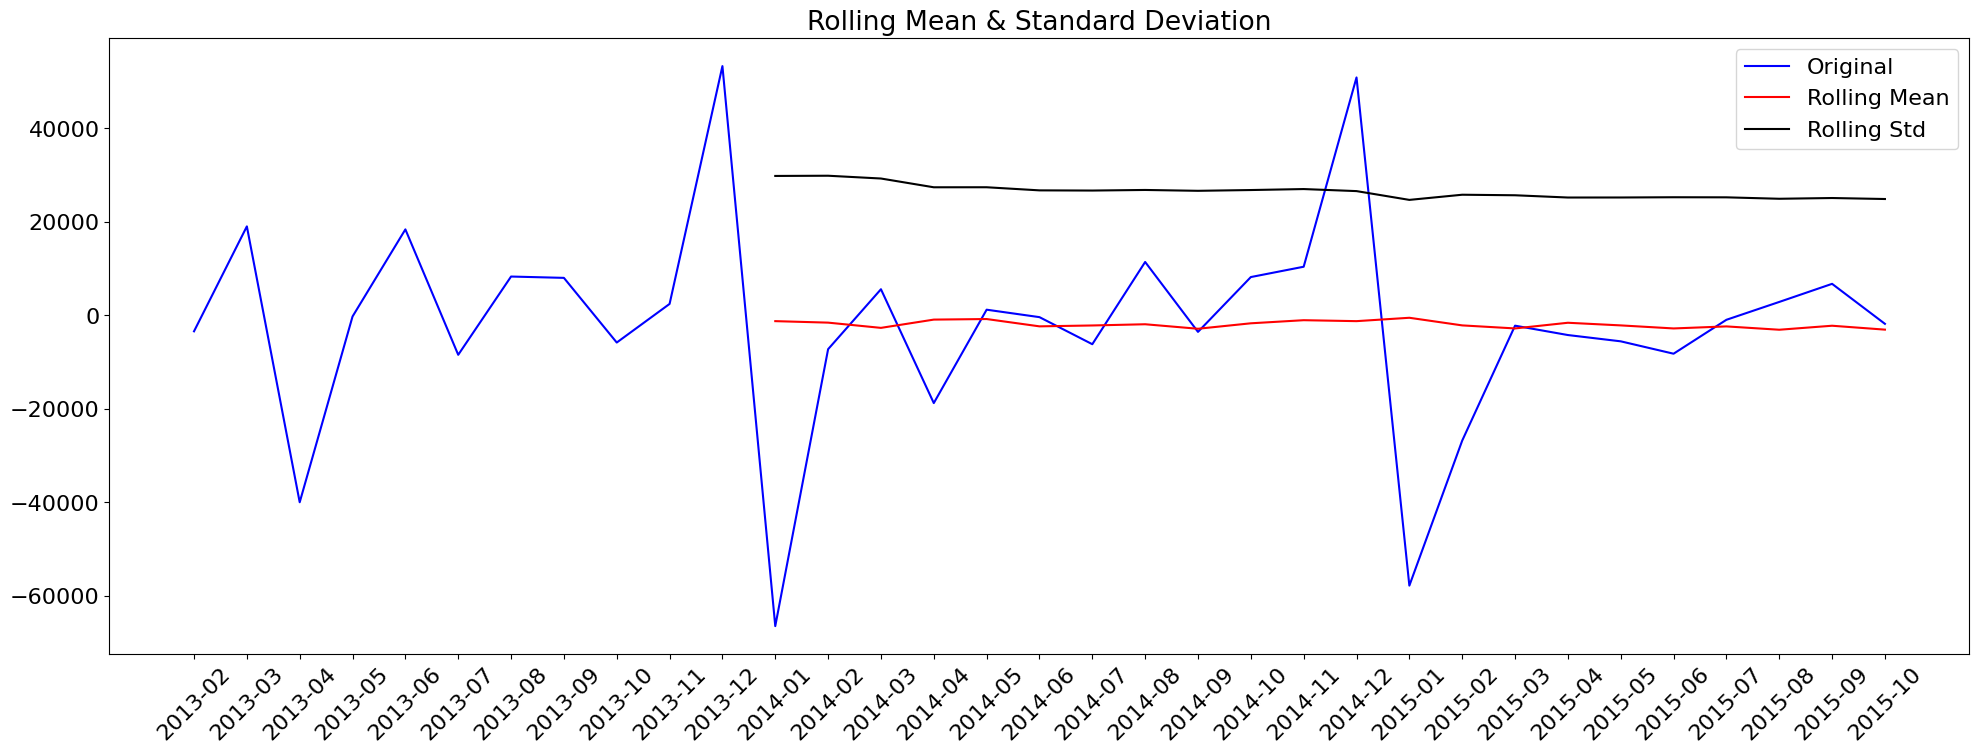

Results of Dickey-Fuller Test:
Test Statistic                -1.363559e+01
p-value                        1.690846e-25
#Lags Used                     1.000000e+01
Number of Observations Used    2.200000e+01
Critical Value (1%)           -3.769733e+00
Critical Value (5%)           -3.005426e+00
Critical Value (10%)          -2.642501e+00
dtype: float64


In [19]:
plt.rcParams.update({'font.size': 16})
ts_diff=ts-ts.shift()
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

The Dickey-Fuller test statistic and p value are significantly lower than the 1% critical value and  0.05 respectively, so we can say that TS is close to stationary with 99% confidence.

**Removing seasonality by differencing**

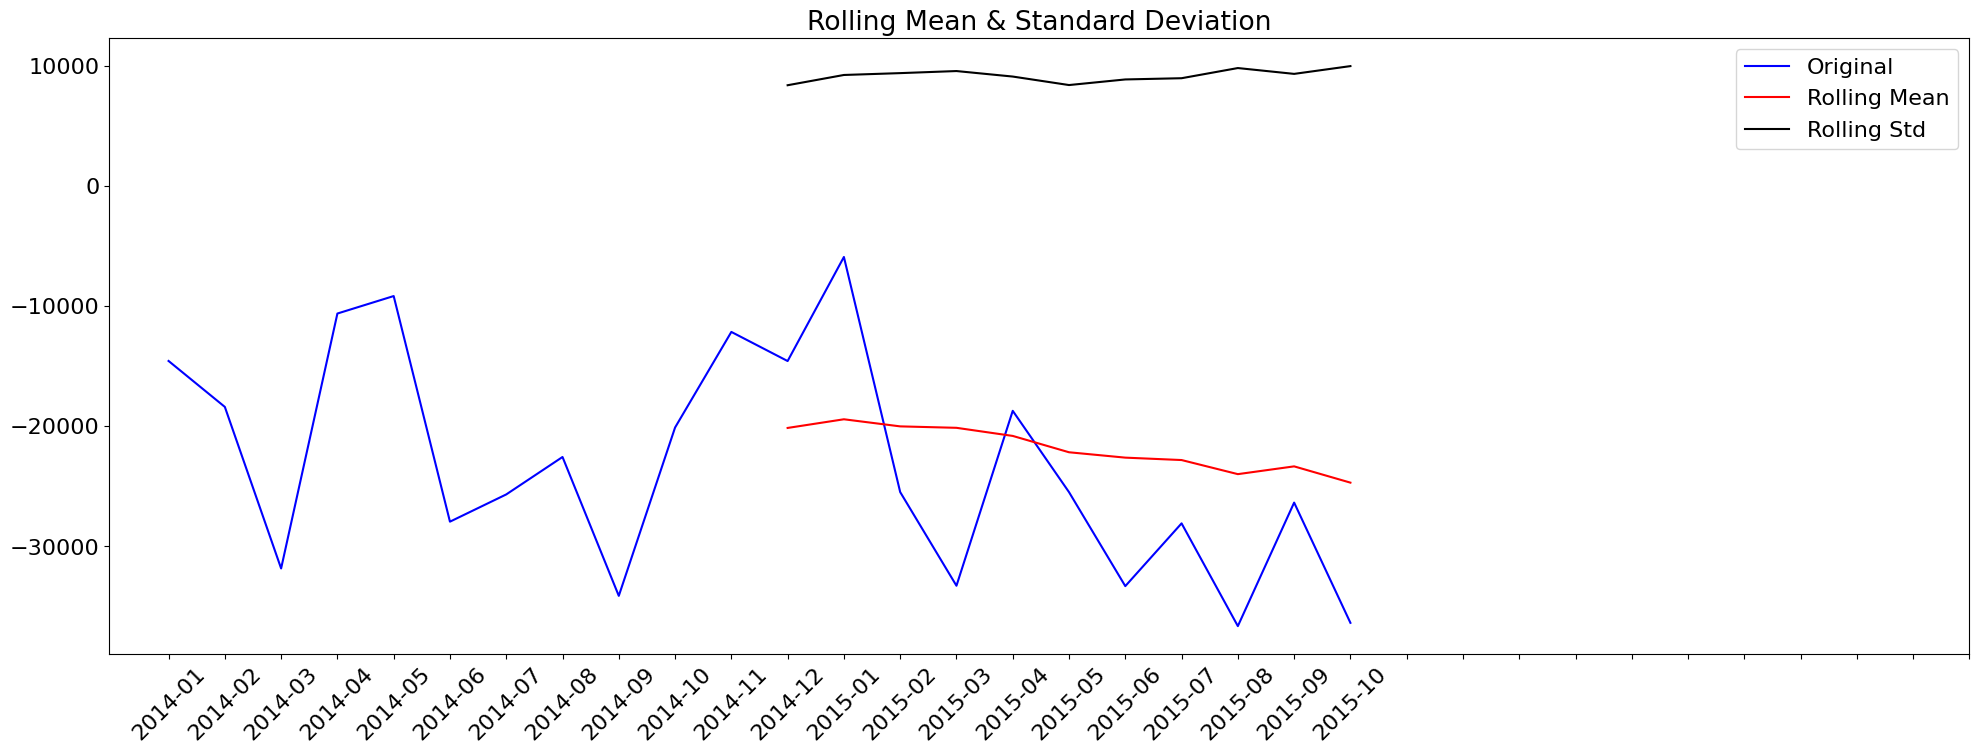

Results of Dickey-Fuller Test:
Test Statistic                 -3.270000
p-value                         0.016274
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


In [20]:
ts_seasonal_diff=ts-ts.shift(12)
ts_seasonal_diff.dropna(inplace=True)
test_stationarity(ts_seasonal_diff)

Can still see a trend in the graph, so cannot accept it. Also, test statistic is not good.

**De trend by log transform**

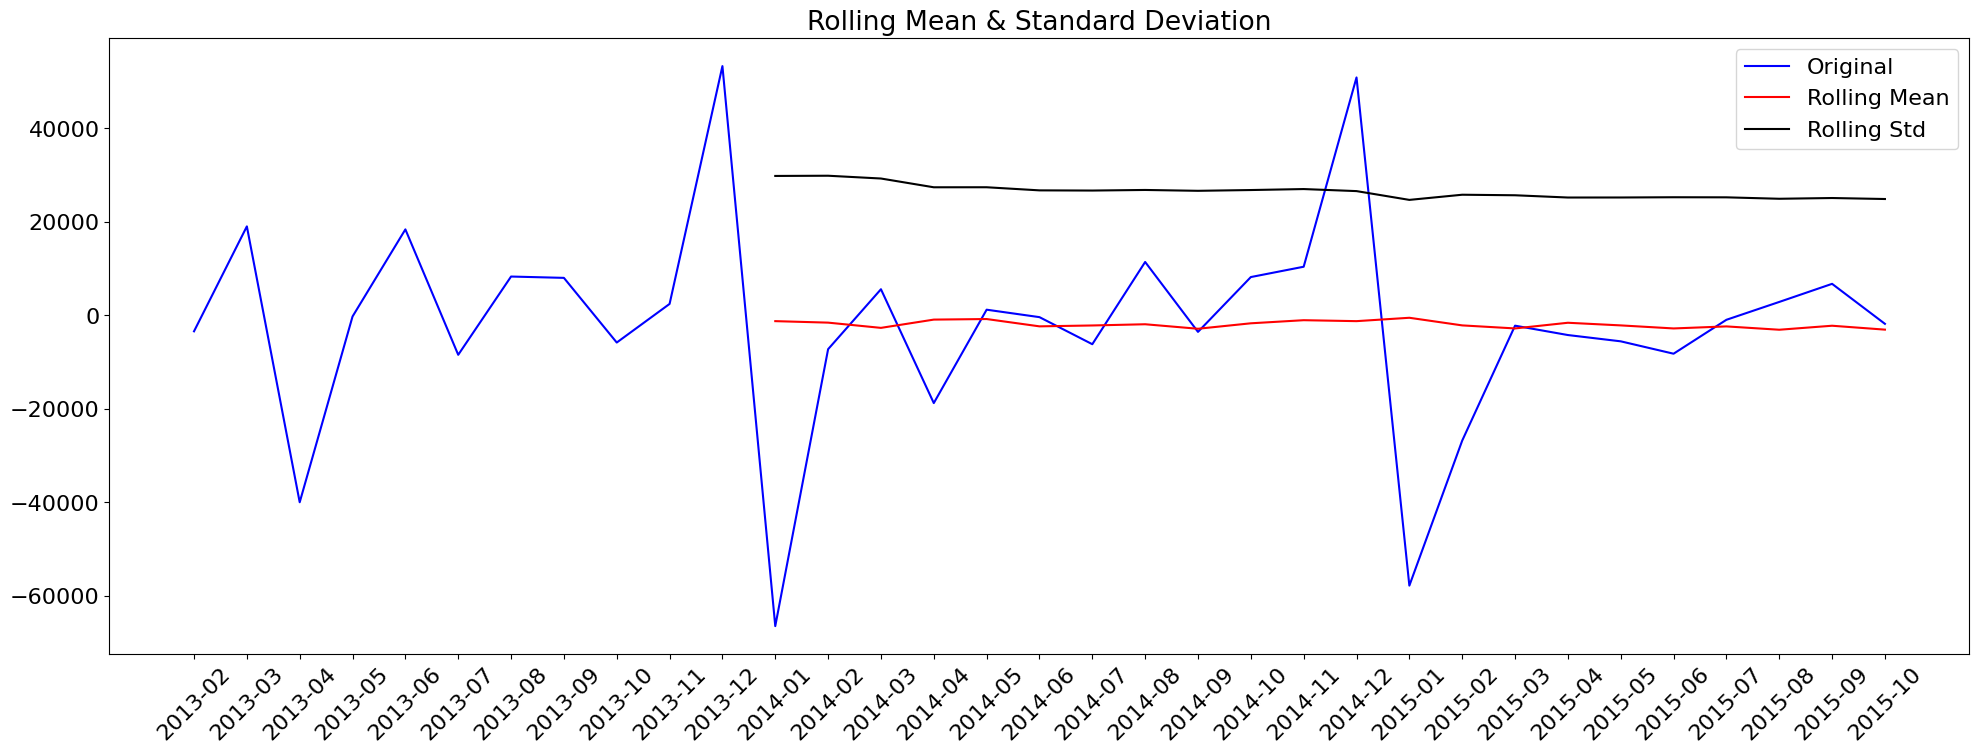

Results of Dickey-Fuller Test:
Test Statistic                -1.363559e+01
p-value                        1.690846e-25
#Lags Used                     1.000000e+01
Number of Observations Used    2.200000e+01
Critical Value (1%)           -3.769733e+00
Critical Value (5%)           -3.005426e+00
Critical Value (10%)          -2.642501e+00
dtype: float64


In [21]:
ts_log=ts-ts.shift()
ts_log.dropna(inplace=True)
test_stationarity(ts_log)

p>0.05, so it is not stationary. <br>

From all the above options, we will move ahead with de trending with differencing which gave us the best best results so far

In [22]:
ts_original=ts.copy()

### ARIMA MODEL

Now let us fit a model but at this point we arent sure of the model parameters which is defined below-
- Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. 
- Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. 
- Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference to stationarize the series.

PACF and ACF will help us determine p and q values.<br>

let us plot for both the time series - stationarized and non stationarized time series



c:\Users\adityam\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


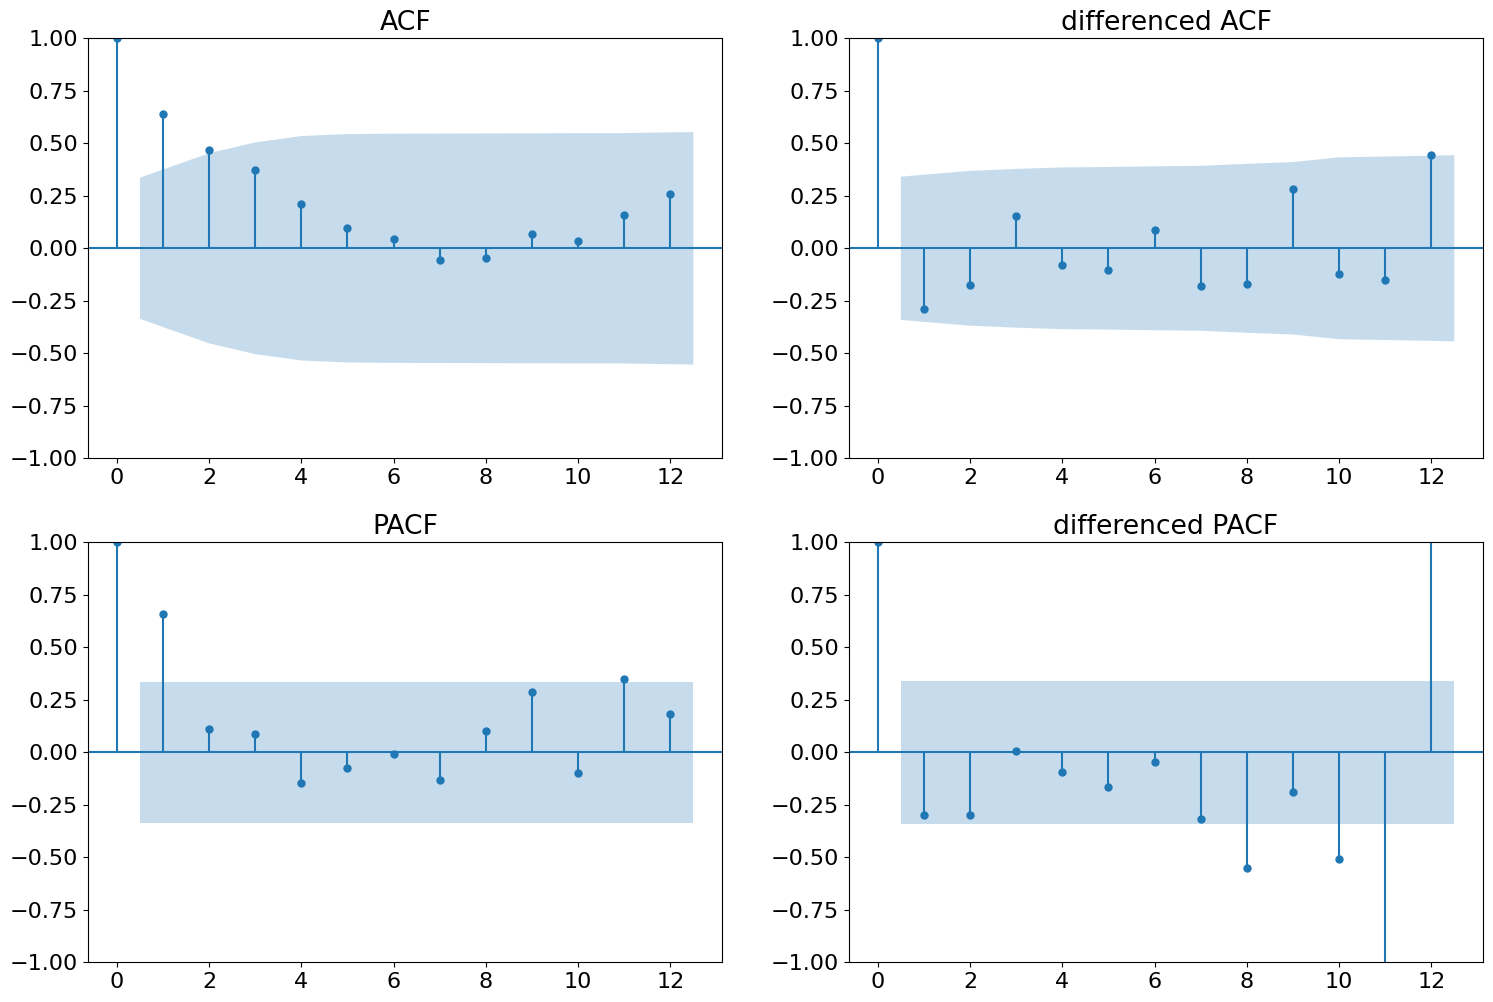

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(18,12))
ax[0, 0] = plot_acf(ts, ax=ax[0, 0], lags=12, title="ACF")
ax[1, 0] = plot_pacf(ts, ax=ax[1, 0], lags=12, title="PACF")

ax[0, 1] = plot_acf(ts_diff , ax=ax[0, 1], lags=12, title="differenced ACF")
ax[1, 1] = plot_pacf(ts_diff, ax=ax[1, 1], lags=12, title="differenced PACF")

We can see that, p=q=1 approximately. Let us again verify with a different type of plot to derive p and q values. <br>
It is said that most of the sample autocorrelation coefficients lie within the limits (-1.96/sqrt(N)) and (+1.96/sqrt(N)) where N is the number of observations

Now, lets make 4 different ARIMA models with considering individual as well as combined effects <br>
We will take the non stationarized time series with d=1 (as proved earlier)

In [33]:
ts

Month-Year
2013-01    131479
2013-02    128090
2013-03    147142
2013-04    107190
2013-05    106970
2013-06    125381
2013-07    116966
2013-08    125291
2013-09    133332
2013-10    127541
2013-11    130009
2013-12    183342
2014-01    116899
2014-02    109687
2014-03    115297
2014-04     96556
2014-05     97790
2014-06     97429
2014-07     91280
2014-08    102721
2014-09     99208
2014-10    107422
2014-11    117845
2014-12    168755
2015-01    110971
2015-02     84198
2015-03     82014
2015-04     77827
2015-05     72295
2015-06     64114
2015-07     63187
2015-08     66079
2015-09     72843
2015-10     71053
Name: Total_products_sold, dtype: int32

In [24]:
import pmdarima as pm

# Use auto_arima to automatically find the best ARIMA model order
model = pm.auto_arima(ts, seasonal=False, stepwise=True, trace=True)

# Fit the best model
model.fit(ts)
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=760.247, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=760.752, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=760.715, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=758.472, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=762.780, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.443 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   34
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -378.236
Date:                Wed, 25 Oct 2023   AIC                            758.472
Time:                        18:03:34   BIC                            759.969
Sample:                    01-01-2013   HQIC                           758.976
                    

It can be seen that ARIMA(1,1,1) performs best as expected.

In [25]:
# ts_df=ts_df.reset_index()
ts_df=pd.DataFrame(ts)
# ts_df

In [68]:
ts.shape

(34,)

In [26]:

model = sm.tsa.ARIMA(ts, order= (1, 1, 1))
res_all = model.fit()

c:\Users\adityam\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\adityam\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\adityam\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


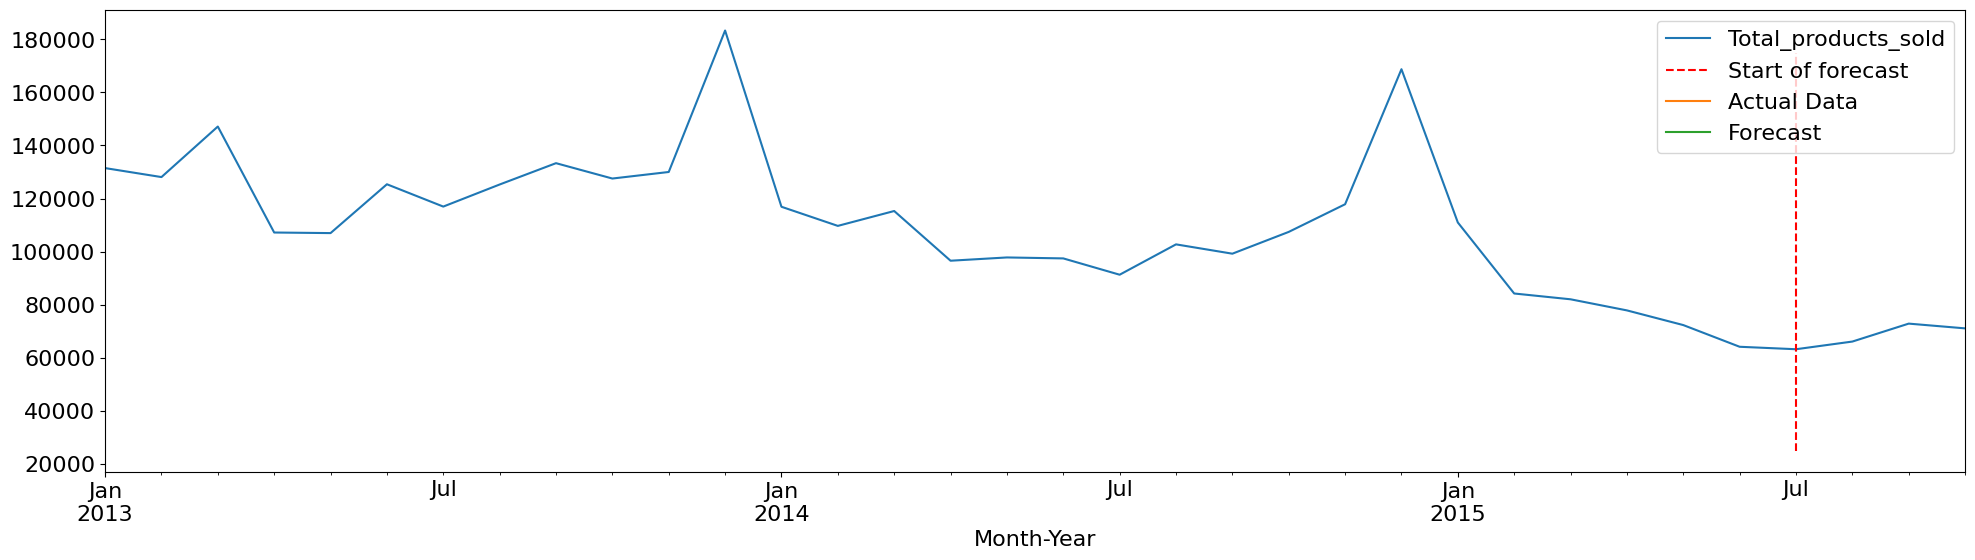

In [27]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(24, 6));

ts_df.index = pd.to_datetime(ts_df.index, format="%Y-%m");
ts_df.Total_products_sold.plot(ax=ax);

ax.vlines('2015-07',25000,175000, linestyle='--', color='r', label='Start of forecast');
forecast = res_all.forecast(steps=5) 
data=ts_df
# Plot actual data and forecast
plt.plot(data, label='Actual Data')
plt.plot(range(len(data), len(data) + len(forecast)), forecast, label='Forecast')
#plt.fill_between(range(len(data), len(data) + len(forecast)), forecast - stderr, forecast + stderr, color='gray', alpha=0.2, label='95% Prediction Interval')
plt.legend()
plt.show()

In [98]:
res_all.plot_predict(start ='2013-05', end = '2015-10', dynamic = True, plot_insample=False, ax=ax);

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'

Clearly the seasonal variations are not considered in the model.

Let us search optimal parameters for the ARIMA model and compare it with the one above

In [28]:
import statsmodels.tsa.api as smt
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        for k in rng:
            try:
                tmp_mdl = ARIMA(ts, order=(i, j,k)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, j,k)
                    best_mdl = tmp_mdl
            except: continue
             
                

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

c:\Users\adityam\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\adityam\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\adityam\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\adityam\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\adityam\AppData\Local\Programs\Python\P

aic: 2.00000 | order: (0, 3, 0)


c:\Users\adityam\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Lets us fit the ARIMA model**<br>
Converted the values to logarithmic values

In [54]:
ts

Month-Year
2013-01    131479
2013-02    128090
2013-03    147142
2013-04    107190
2013-05    106970
2013-06    125381
2013-07    116966
2013-08    125291
2013-09    133332
2013-10    127541
2013-11    130009
2013-12    183342
2014-01    116899
2014-02    109687
2014-03    115297
2014-04     96556
2014-05     97790
2014-06     97429
2014-07     91280
2014-08    102721
2014-09     99208
2014-10    107422
2014-11    117845
2014-12    168755
2015-01    110971
2015-02     84198
2015-03     82014
2015-04     77827
2015-05     72295
2015-06     64114
2015-07     63187
2015-08     66079
2015-09     72843
2015-10     71053
Name: Total_products_sold, dtype: int32

c:\Users\adityam\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\adityam\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\adityam\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\adityam\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


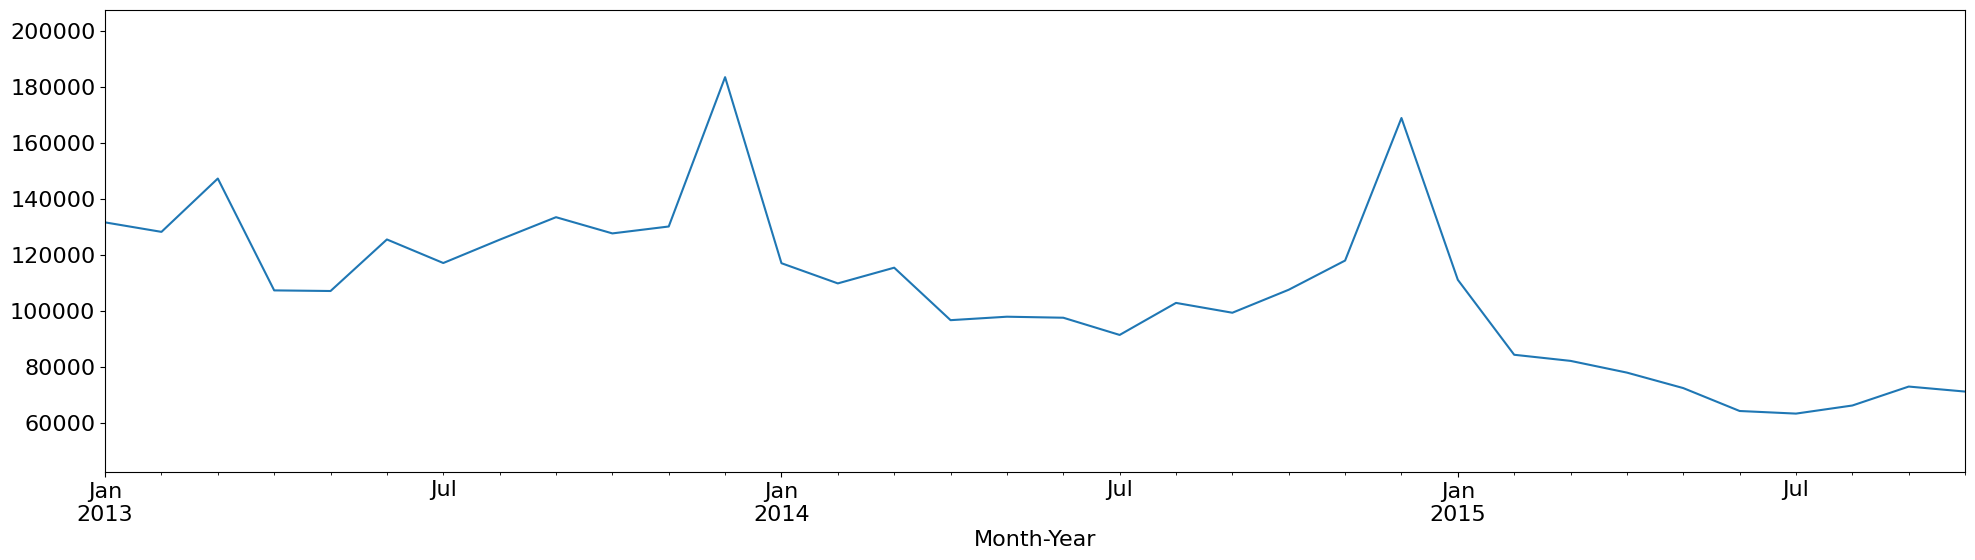

In [29]:
model = sm.tsa.ARIMA(ts, order=(0, 3, 0))
res_opt = model.fit()

fig, ax = plt.subplots(figsize=(24, 6));

ts_df.index = pd.to_datetime(ts_df.index, format="%Y-%m");
ts_df.Total_products_sold.dropna().plot(ax=ax)
ax.vlines('2015-11',50000,200000, linestyle='--', color='r', label='Start of forecast');
#res_opt.plot_predict(start = '2013-04', end = '2016-10', dynamic = True, plot_insample=False, ax=ax);

**Before rejecting the above models,let us check the residual mean for both the models**

In [30]:
print(f"The mean for ARIMA(1,1,1) is {np.mean(res_all.resid)}")
print(f"The mean for ARIMA(0,3,0) is {np.mean(res_opt.resid)}")

The mean for ARIMA(1,1,1) is 3229.3981647776586
The mean for ARIMA(0,3,0) is -3916621.715686422


**Definitely the models are not performing well with ARIMA due to yearly seasonal variations**<br>
Let us move ahead with Seasonal ARIMA after finding the optimal parameters

The code chunk below iterates through combinations of parameters and uses the SARIMAX function from statsmodels to fit the corresponding Seasonal ARIMA model. Here, the order argument specifies the (p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal component of the Seasonal ARIMA model. After fitting each SARIMAX()model, the code prints out its respective AIC score.

In [31]:
best_aic=np.inf
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            tmp_aic=results.aic
            if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = param
                    best_seasonal = param_seasonal

#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
        except:
            continue
            
print('aic: {:6.5f} | order: {} | seasonal_order {}'.format(best_aic, best_order, best_seasonal))

c:\Users\adityam\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\adityam\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\adityam\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\adityam\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\adityam\AppData\Local\Programs\Python\P

aic: 144.22138 | order: (1, 1, 1) | seasonal_order (0, 1, 1, 12)


**Fitting the seasonal ARIMA with optimal parameters**

In [33]:
mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9508      0.657     -1.447      0.148      -2.239       0.337
ma.L1         -0.4727      0.284     -1.666      0.096      -1.029       0.083
ma.S.L12       0.3070      0.237      1.293      0.196      -0.158       0.772
sigma2      1.638e+07   1.31e-08   1.25e+15      0.000    1.64e+07    1.64e+07


c:\Users\adityam\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\adityam\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\adityam\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


**Our data is till Oct-2015. Predicting till May 2016**

In [32]:
pred = results.get_prediction(start=pd.to_datetime('2013-01-01'), end=pd.to_datetime('2016-05-01'), dynamic=False)
pred_ci = pred.conf_int()

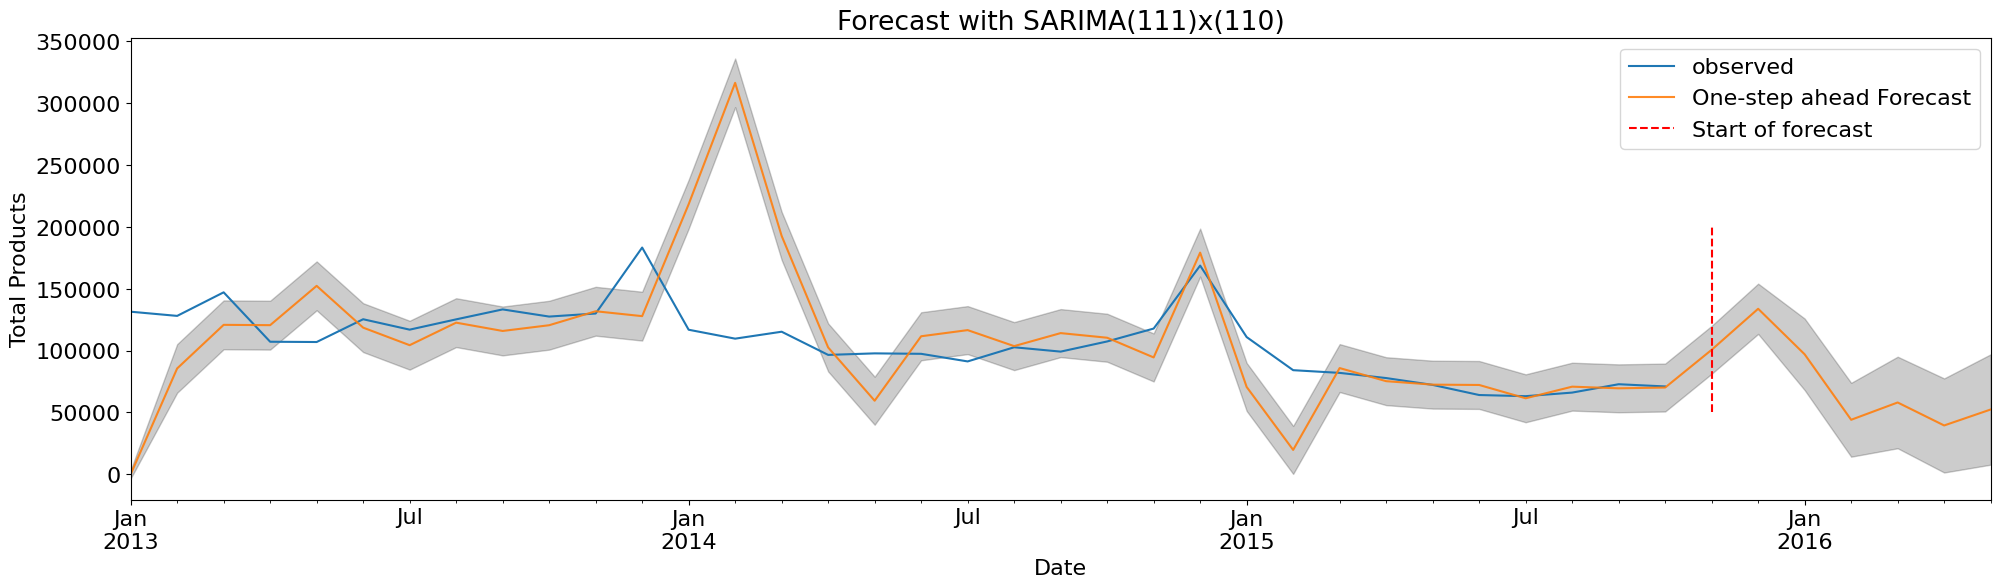

In [34]:
# plt.figure(figsize=(24,8))
fig, ax = plt.subplots(figsize=(24, 6));
ax=ts_df['Total_products_sold'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

ax.vlines('2015-11-01',50000,200000, linestyle='--', color='r', label='Start of forecast');
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Total Products')
plt.legend()
plt.title("Forecast with SARIMA(111)x(110)")
plt.show()



**It is always better to quantify the accuracy of our forecasts. We will use mean of residuals and the MSE (Mean Squared Error), which summarizes the average error**

In [35]:
y_predict = results.get_prediction(start=pd.to_datetime('2013-01-01'), end=pd.to_datetime('2015-10-01'), dynamic=False)

y_forecasted = y_predict.predicted_mean
y_truth = ts_df.Total_products_sold

residual_mean=np.mean(y_forecasted - y_truth)

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The mean of residuals is {}'.format(round(residual_mean, 2)))

The Mean Squared Error of our forecasts is 2408376367.28
The mean of residuals is 3773.54
